<a href="https://colab.research.google.com/github/gutakeda/mvp-machine-learning-backend/blob/main/machine-learning/notebooks/Heart_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Engenharia de Sistemas de Software Inteligentes - Profs. Marcos Kalinowski e Tatiana Escovedo
## Aula 02: Prática de Machine Learning em Python

In [1]:
# configuração para não exibir os warnings - editing
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import json
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## Carga do Dataset

In [12]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/gutakeda/mvp-machine-learning-collab/main/heart.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Cria um dicionário para armazenar os mapeamentos
mapping_dict = {}

# Aplica LabelEncoder a cada coluna categórica
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Verifica se a coluna é categórica
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        mapping_dict[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Exibe o dataset transformado
dataset.head()

# Salva o mapeamento em um arquivo json
with open('mapping.json', 'w') as f:
    json.dump(mapping_dict, f)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:11]
y = array[:,11]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.713791 (0.050067)
CART: 0.809348 (0.036109)
NB: 0.852962 (0.042897)
SVM: 0.728971 (0.030971)


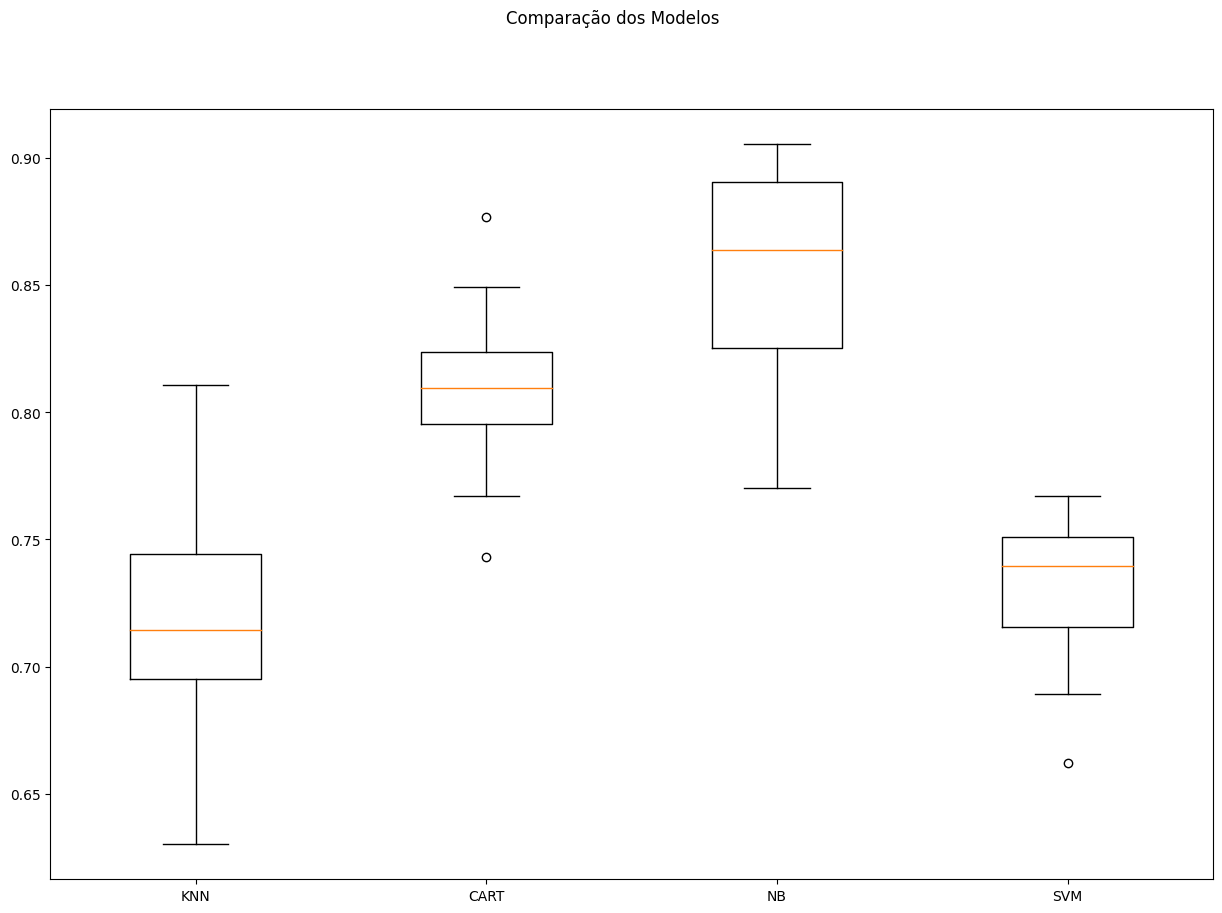

In [4]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.714 (0.050)
CART-orig: 0.809 (0.036)
NB-orig: 0.853 (0.043)
SVM-orig: 0.729 (0.031)
KNN-padr: 0.857 (0.032)
CART-padr: 0.798 (0.025)
NB-padr: 0.853 (0.043)
SVM-padr: 0.868 (0.033)
KNN-norm: 0.849 (0.033)
CART-norm: 0.801 (0.040)
NB-norm: 0.853 (0.043)
SVM-norm: 0.865 (0.040)


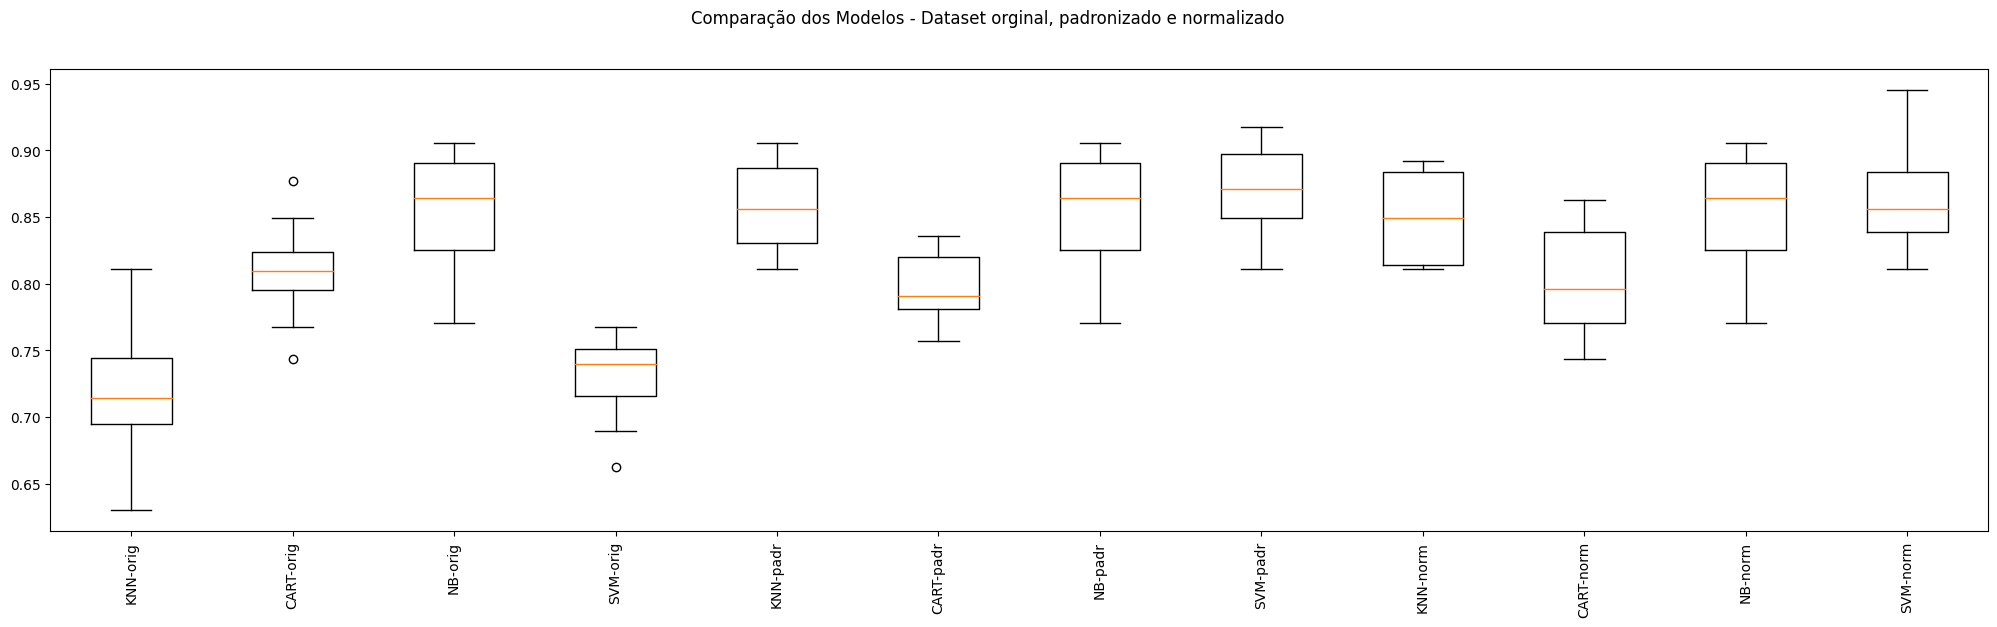

In [5]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [6]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.761699 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.881470 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Sem tratamento de missings: knn-norm - Melhor: 0.863773 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}


## Finalização do Modelo

In [7]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.875


In [8]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

## Salvando os Arquivos

In [9]:
# Salvando o modelo
model_filename = 'rf_heart_disease_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'minmax_scaler_heart_disease.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvando o pipeline
pipeline_filename = 'rf_heart_disease.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipelines, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_heart_disease.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_heart_disease.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../models/rf_heart_disease_classifier.pkl'

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
dataset.head()

In [ ]:
# Novos dados - não sabemos a classe!
data = {
        'age': [12],
        'sex': [1],
        'chest': [1],
        'rest': [41],
        'cholesterol': [147],
        'fasting': [0],
        'resting': [1],
        'max': [98],
        'exercise': [0],
        'oldpeak': [10],
        'stslope': [2],
        }


atributos = ['age', 'sex', 'chest', 'rest', 'cholesterol', 'fasting', 'resting', 'max', 'exercise', 'oldpeak', 'stslope']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)

print(rescaledEntradaX)

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)